### Machine Learning based blood segmentation and cell detection

In [3]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import torchvision.models.segmentation
import torch
import os

from PIL import Image
import pandas as pd

from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt

import transforms as T
import utils

In [24]:
def get_image_label(img_path, annotations, transforms = None):
    img = Image.open(img_path).convert("RGB")
    mask = np.zeros([np.shape(img)[0], np.shape(img)[1]], dtype=np.uint8)

    boxes = []
    labels = []

    # Convert celltypes to class index
    celltypes = {
        "RBC": 1, 
        "WBC": 2, 
        "Platelets" : 3, 
        "Background": 0}

    masks = []

    tmp = 1

    for index, row in annotations.iterrows():
        if row.ymax == row.ymin:
            continue
        if row.xmax == row.xmin:
            continue

        boxes.append([row.xmin, row.ymin, row.xmax, row.ymax])
        labels.append(celltypes[row.cell_type])

        mask[row.ymin:row.ymax, row.xmin:row.xmax] = tmp
        tmp = tmp + 1

    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]

    # split the color-encoded mask into a set
    # of binary masks
    masks = (mask == obj_ids[:, None, None])
    
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    #image_id = torch.tensor([idx])

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    #target["image_id"] = image_id
    target["area"] = area
    target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)

    num_objs = len(obj_ids)
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target["iscrowd"] = iscrowd
    
    if transforms is not None:
        img, target = transforms(img, target)

    return img, target

def extract_annotation(root, img_file):
    df = pd.read_csv(os.path.join(root, 'test.csv'))
    
    img_path = os.path.join(root, 'BCCD/JPEGImages/', img_file)
    annotations = df.loc[df['filename'] == img_file]
    
    return img_path, annotations

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [45]:
def pil_smear(img, xmin,ymin,xmax,ymax,ctype=None):
    #print(ctype)
    celltypes = {
            "RBC": 1, 
            "WBC": 2, 
            "Platelets" : 3, 
            "Background": 0}
    
    for key, val in celltypes.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
        if val == ctype:
            col = key
            if val == 3:
                col = "P"
            break
    
    draw = ImageDraw.Draw(img)
    draw.rectangle(((xmin, ymin), (xmax, ymax)))
    draw.text((xmin+10, ymin+10), col, font=ImageFont.load_default().font)


    return img

def plot_ann(image, my_target):
    #image = image.transpose(1, 2, 0).astype(np.uint8)
    boxes = my_target['boxes'].detach().to('cpu').numpy().astype(np.uint32)
    num_b, _ = boxes.shape

    tmpi = Image.fromarray(image)

    for i in range(num_b):
        if 'scores' in my_target:
            if my_target['scores'][i] > 0.5:
                tmpi = pil_smear(tmpi, boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3], ctype=my_target['labels'][i].detach())
        else:
            tmpi = pil_smear(tmpi, boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3], ctype=my_target['labels'][i].detach())

    return tmpi

In [38]:
#instantiate torch pretrained model
def get_torch_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # load an instance segmentation model pre-trained pre-trained on COCO
    in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=num_classes)  # replace the pre-trained head with a new one
    
    return model

#Load BCCD finetuned model
def finetune(model, saved_model, device):
    model.load_state_dict(torch.load(saved_model))
    model.to(device)
    
    return model

Text(0.5, 1.0, 'Predicted')

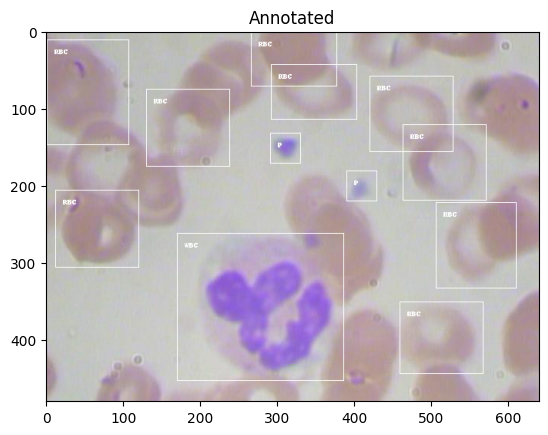

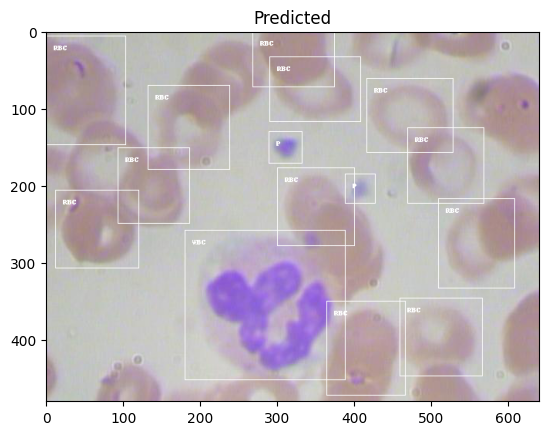

In [53]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Infer from BCCD finetuned model
model = get_torch_model(num_classes = 4) # RBC, WBC, Platelets, Background
model = finetune(model, 'retrain_1570.torch', device)

model.eval()

root = '../BCCD_Dataset'
file = 'BloodImage_00203.jpg'

img_path, annotation = extract_annotation(root, file)
img, target = get_image_label(img_path, annotation, get_transform(False))

img = img.to(device)

pred = model([img])

img = (img.detach().to('cpu').numpy() * 255)
tmp = img.transpose(1, 2, 0).astype(np.uint8)

pred_pil = plot_ann(tmp, pred[0])
img_pil = plot_ann(tmp, target)

plt.imshow(img_pil)
plt.title('Annotated')

plt.figure()
plt.imshow(pred_pil)
plt.title('Predicted')

In [49]:
# Create training dataset based on BCCD 
# Using https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html as reference
class BCCDDataset(torch.utils.data.Dataset):
    def __init__(self, root='../BCCD_Dataset', transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'BCCD/JPEGImages/'))))
        self.df = pd.read_csv(os.path.join(root, 'test.csv'))

    def __getitem__(self, idx):
        #print(idx)
        # Load image
        img_path = os.path.join(self.root, 'BCCD/JPEGImages/', self.imgs[idx])
        annotations = self.df.loc[self.df['filename'] == self.imgs[idx]]

        img, target = get_image_label(img_path, annotations, self.transforms)
        
        target["image_id"] = torch.tensor([idx])

        return img, target

    def __len__(self):
        return len(self.imgs)

In [50]:
def train_model(model, dataloader_train, dataloader_val, device, num_epochs=10, save_prefix='retrain_'):
    my_iter = 0
    
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = []
        for i , (images, targets) in enumerate(dataloader_train):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

            my_iter = my_iter + 1

            if (my_iter % 20 == 0):
                print(my_iter,'loss:', losses.item())

            train_loss.append(losses.item())

            if my_iter % 500==0:
                torch.save(model.state_dict(), save_prefix + str(my_iter)+".torch")

        print('Training loss at epoch {} {}'.format(epoch, np.mean(train_loss)))

        #model.eval()
        valid_loss = []
        for i , (images, targets) in enumerate(data_loader_test):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                val_loss_dict = model(images, targets)

            losses = sum(loss for loss in val_loss_dict.values())

            valid_loss.append(losses.item())

        print('Validation loss at epoch {} {}'.format(epoch, np.mean(valid_loss)))

    final_model = save_prefix + str(my_iter)+".torch"
    torch.save(model.state_dict(), final_model)
    print('{} Model saved at {} iterations and {} epochs'.format(final_model, my_iter, epoch))

In [52]:
# TRAINING
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Finetune model by training
model = get_torch_model(num_classes = 4) # RBC, WBC, Platelets, Background
model = model.to(device)

#instantiate dataloader
# use our dataset and defined transformations
dataset = BCCDDataset('../BCCD_Dataset', get_transform(train=True))
dataset_test = BCCDDataset('../BCCD_Dataset', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1106)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

model.train()
train_model(model, data_loader, data_loader_test, device, num_epochs=10, save_prefix='retrain_')

20 loss: 1.6278951168060303
40 loss: 1.447397232055664
60 loss: 1.2456361055374146
80 loss: 1.088884949684143
100 loss: 1.2806665897369385
120 loss: 0.8851922750473022
140 loss: 0.993034839630127
Training loss at epoch 0 1.2862826559194334
Validation loss at epoch 0 0.9125110149383545
160 loss: 0.7120970487594604
180 loss: 0.815660834312439
200 loss: 0.9336333870887756
220 loss: 0.8245031237602234
240 loss: 1.019132137298584
260 loss: 0.9513470530509949
280 loss: 0.8672184348106384
300 loss: 0.886807382106781
Training loss at epoch 1 0.8848121860984025
Validation loss at epoch 1 0.8311930477619172
320 loss: 0.7565552592277527
340 loss: 0.7989763617515564
360 loss: 0.5646553635597229
380 loss: 1.174788475036621
400 loss: 1.076076626777649
420 loss: 0.9304532408714294
440 loss: 0.771152675151825
460 loss: 0.7880210876464844
Training loss at epoch 2 0.8165992591411445
Validation loss at epoch 2 0.7974611842632293
480 loss: 1.0020065307617188
500 loss: 0.8110488057136536
520 loss: 0.641342